In [1]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

pd.set_option('max_columns',100)


import os
os.chdir('/Users/shubhamjain/Downloads/AV/IPL/')

In [2]:
## training data

ball_data = pd.read_csv('train/ball_by_ball_data.csv')
match_data = pd.read_csv('train/match_data.csv')
key_teams = pd.read_csv('train/key_teams.csv')
players = pd.read_csv('train/player_rosters.csv')
player_attributes = pd.read_csv('player_attributes.csv')

## test data

test_player = pd.read_csv('test/player_predictions.csv')
test_matches = pd.read_csv('test/matches_2018.csv')
test_extras = pd.read_csv('test/total_extras.csv')

## submission

sub_player = pd.read_csv('sample_submission/player_predictions.csv')
sub_extras = pd.read_csv('sample_submission/total_extras.csv')

In [3]:
batsman = pd.read_csv('saved/final_batsman.csv')
bowler = pd.read_csv('saved/final_bowler.csv')
xi = pd.read_csv('saved/playing_xi.csv')
runs_score = pd.read_csv('saved/runs_score.csv')

### Building features for training data from 2015-16

In [4]:
batsman[batsman['batsman'] == 'J P Duminy']

,batsman,Average,Season_played,total_runs,100s,50s,30+,total_innings,ability,dot%,power_hitting,consistency,avg_first_ing,avg_second_ing,CSK,DD,GL,KKR,KXI,MI,RCB,RPS,RR,SRH,top_order,Team_Consistency,current_rank,Price,country,last_season_runs,role,mom,player_id,Team
19,J P Duminy,125.0,7.0,605,0,4,8,21,0.380952,32.85124,0.130165,40.333333,64.333333,24.333333,5.5,0.0,61.0,15.0,21.0,82.0,87.0,24.0,100.0,27.67,1,0.0,999.0,100.0,Africa,0.0,Batsman,0.714286,677.0,MI


In [5]:
ball_data.loc[ball_data['inning'] == 3,'inning'] = 1
ball_data.loc[ball_data['inning'] == 4,'inning'] = 2

ball_data['season'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[0]).astype('int')
ball_data['match_id'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

match_data['match_id'] = match_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

## selecting only last three seasons
ball_data_3 = ball_data[ball_data['season'] > 2014]
ball_data_3 = ball_data_3.merge(match_data, on =['season', 'match_id'], how='left')

In [6]:
val = ball_data_3[ball_data_3['season'] == 2017]
ball_data_3 = ball_data_3[ball_data_3['season'] < 2017]

In [7]:
## runs scored by each batsman in each match
runs_scored = ball_data_3.groupby(['season','match_id','inning','batsman'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index()

## balls faced
temp = ball_data_3.groupby(['season','match_id','inning','batsman'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'balls_faced'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
del temp

## total runs scored
temp = ball_data_3.groupby(['season','match_id','inning'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index().rename(columns = {'batsman_runs':'total'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning'], how='left')
del temp

## dot balls

temp = ball_data_3.groupby(['season','match_id','inning','batsman'])['batsman_runs'].apply(lambda x: np.count_nonzero(x == 0)).reset_index().rename(columns = {'batsman_runs':'dots'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
del temp

## additional match details
runs_scored = runs_scored.merge(match_data[['season','match_id', 'toss_winner', 'toss_decision','winner',
                             'win_by_runs', 'win_by_wickets', 'player_of_match']] , on =['season','match_id'],how='left')

## batsman team name and aganist team

temp = ball_data_3.groupby(['season','match_id','inning'])[['batting_team','bowling_team']].apply(lambda x: x.head(1)).reset_index().drop('level_3',axis=1)
runs_scored = runs_scored.merge(temp, on =['season','match_id','inning'], how='left')
del temp

In [8]:
## no of hundreds, fifty, and 30+ scores

hundreds = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 100))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'100s'})
fifties = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 50))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'50s'})
thirty = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'30+'})

In [9]:
## check if batsman was out or not out

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()][['season','match_id','inning','player_dismissed']].rename(columns = {'player_dismissed':'batsman'})
temp['is_out'] = 1

runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
runs_scored['is_out'] = runs_scored['is_out'].fillna(0)

In [10]:
## batsman data
batsman_data = pd.DataFrame(runs_scored['batsman'].unique(), columns= ['batsman'])

In [11]:
## average in each innings = total runs score in that innings/ total innings in which we got out

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['batsman_runs'].apply(lambda x: np.sum(x))
             /runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'avg_first_ing'}).fillna(0)

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['avg_first_ing'] == np.inf, 'avg_first_ing'] = 0

## 2nd inngs
temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['batsman_runs'].apply(lambda x: np.sum(x))
             /runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'avg_second_ing'}).fillna(0)

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['avg_second_ing'] == np.inf, 'avg_second_ing'] = 0

In [12]:
## no of dots/ no of balls faced

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 2].groupby('batsman')['dots'].apply(lambda x: x.sum() *100)/ (runs_scored[runs_scored['inning'] == 2].groupby('batsman')['balls_faced'].apply(lambda x: x.sum()))).reset_index().rename(columns = {0:'dot%2'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 1].groupby('batsman')['dots'].apply(lambda x: x.sum() *100)/ (runs_scored[runs_scored['inning'] == 1].groupby('batsman')['balls_faced'].apply(lambda x: x.sum()))).reset_index().rename(columns = {0:'dot%1'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

In [13]:
## total runs scored

temp = runs_scored[runs_scored['inning'] == 1].groupby('batsman')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':'total_runs1'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

temp = runs_scored[runs_scored['inning'] == 2].groupby('batsman')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':'total_runs2'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

In [14]:
## no of innings played

temp = runs_scored.loc[runs_scored['inning'] == 2, 'batsman'].value_counts().reset_index()
temp.columns = ['batsman','total_innings_2']
batsman_data = batsman_data.merge(temp, on='batsman', how='left')

temp = runs_scored.loc[runs_scored['inning'] == 1, 'batsman'].value_counts().reset_index()
temp.columns = ['batsman','total_innings_1']
batsman_data = batsman_data.merge(temp, on='batsman', how='left')

In [15]:
## no of centuries, fifties and 30+

batsman_data = batsman_data.merge(hundreds, on='batsman', how='left')
batsman_data = batsman_data.merge(fifties, on='batsman', how='left')
#batsman_data = batsman_data.merge(thirty, on='batsman', how='left')

thirty_2 = (runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    ={'batsman_runs':'30+_2'})

thirty_1 = (runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'30+_1'})

batsman_data = batsman_data.merge(thirty_2, on='batsman', how='left')
batsman_data = batsman_data.merge(thirty_1, on='batsman', how='left')

In [16]:
## ability to score every time 30+/innings

batsman_data['ability1'] = batsman_data['30+_1']/batsman_data['total_innings_1']
batsman_data['ability2'] = batsman_data['30+_2']/batsman_data['total_innings_2']

In [17]:
## player of match / total inngs

batsman_data['mom_1'] = batsman_data['batsman']
batsman_data['mom_1'] = batsman_data['mom_1'].map(runs_scored.loc[runs_scored['inning'] == 1, 'player_of_match'].value_counts()).fillna(0).astype('int')

batsman_data['mom_1'] = batsman_data['mom_1']/batsman_data['total_innings_1']

batsman_data['mom_2'] = batsman_data['batsman']
batsman_data['mom_2'] = batsman_data['mom_2'].map(runs_scored.loc[runs_scored['inning'] == 2, 'player_of_match'].value_counts()).fillna(0).astype('int')

batsman_data['mom_2'] = batsman_data['mom_2']/batsman_data['total_innings_2']

In [18]:
## top order, price and current rank

batsman = pd.read_csv('saved/new_batsman.csv')
df = batsman[['top_order','Price','current_rank','batsman']]
batsman_data = batsman_data.merge(df, on='batsman', how='left')

In [19]:
batsman_data.fillna(0, inplace=True)

In [20]:
batsman_data[batsman_data['batsman'] == 'KL Rahul']

,batsman,avg_first_ing,avg_second_ing,dot%2,dot%1,total_runs1,total_runs2,total_innings_2,total_innings_1,100s,50s,30+_2,30+_1,ability1,ability2,mom_1,mom_2,top_order,Price,current_rank
48,KL Rahul,50.5,29.5,32.258065,38.392857,303.0,236.0,9.0,11.0,0,4,4.0,4.0,0.363636,0.444444,0.0,0.0,1,1100.0,999.0


In [21]:
## adding role

batsman_data = batsman_data.merge(player_attributes[['player_name', 'role']].rename(
    columns= {'player_name':'batsman'}), on= 'batsman',how='left')

In [22]:
## adding some more features

In [26]:
## less than 10 scored

temp = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x <= 10))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'10-'})

batsman_data = batsman_data.merge(temp, on='batsman', how='left')


## consistency = number of runs / no of innings in which he got out

temp = pd.DataFrame(runs_scored.groupby('batsman')['batsman_runs'].apply(lambda x: np.sum(x))/runs_scored.groupby('batsman')['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'consistency'})

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['consistency'] == np.inf, 'consistency'] = 0
del temp

In [33]:
batsman_data

,batsman,avg_first_ing,avg_second_ing,dot%2,dot%1,total_runs1,total_runs2,total_innings_2,total_innings_1,100s,30+_2,30+_1,ability1,ability2,mom_1,mom_2,top_order,Price,current_rank,role,10-,consistency,50s
0,Aaron Finch,20.833333,41.571429,41.880342,45.454545,125.0,291.0,8.0,7.0,0,4.0,2.0,0.285714,0.500000,3.285714,2.625000,1,620.0,4.0,Batsman,7,32.000000,5
1,Aditya Tare,7.500000,3.500000,45.454545,63.636364,15.0,7.0,2.0,2.0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,20.0,999.0,WK-Batsman,4,5.500000,0
2,Ambati Rayudu,28.636364,33.333333,38.056680,31.896552,315.0,300.0,11.0,15.0,0,6.0,4.0,0.266667,0.545455,0.400000,0.818182,1,220.0,999.0,WK-Batsman,8,30.750000,3
3,Corey Anderson,54.500000,5.000000,81.818182,49.425287,109.0,5.0,1.0,3.0,0,0.0,2.0,0.666667,0.000000,0.000000,0.000000,0,0.0,73.0,Batting Allrounder,2,38.000000,2
4,Rohit Sharma,28.812500,56.666667,32.731959,35.294118,461.0,510.0,13.0,17.0,0,7.0,7.0,0.411765,0.538462,2.117647,2.461538,1,1500.0,17.0,Batsman,8,38.840000,8
5,Gautam Gambhir,33.636364,30.533333,40.632603,33.887043,370.0,458.0,17.0,11.0,0,7.0,6.0,0.545455,0.411765,0.818182,0.235294,1,280.0,999.0,Batsman,7,31.846154,8
6,Manish Pandey,28.625000,22.181818,34.905660,31.515152,229.0,244.0,15.0,8.0,0,3.0,4.0,0.500000,0.200000,0.000000,0.000000,1,1100.0,50.0,Batsman,6,24.894737,2
7,Robin Uthappa,27.272727,28.625000,37.101449,38.016529,300.0,458.0,17.0,11.0,0,7.0,5.0,0.454545,0.411765,0.909091,0.352941,1,640.0,999.0,WK-Batsman,6,28.074074,4
8,Surya Kumar Yadav,13.500000,25.800000,34.736842,39.726027,81.0,258.0,14.0,10.0,0,2.0,0.0,0.000000,0.142857,0.700000,0.642857,0,0.0,999.0,Batsman,12,21.187500,1
9,Yusuf Pathan,72.500000,47.875000,37.630662,27.358491,290.0,383.0,14.0,11.0,0,6.0,5.0,0.454545,0.428571,1.454545,1.000000,0,190.0,999.0,Batting Allrounder,6,56.083333,4


### formulating training data

In [35]:
## just training for first inngs

val1 = val[val['inning'] == 1]
val1 = val1.groupby(['season','match_id','inning','bowling_team','venue_id','batsman'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index()

In [34]:
df = batsman_data[['batsman', 'avg_first_ing', 'dot%1', 'total_runs1', 'total_innings_1', 'ability1', '30+_1', 'mom_1', 
             'top_order', 'Price','current_rank','role', '10-', 'consistency', '50s']]

In [36]:
val1 = val1.merge(df,on='batsman', how='left')
val1.head()

,season,match_id,inning,bowling_team,venue_id,batsman,batsman_runs,avg_first_ing,dot%1,total_runs1,total_innings_1,ability1,30+_1,mom_1,top_order,Price,current_rank,role,10-,consistency,50s
0,2017,1,1,RCB,4,Ben Cutting,16,39.000000,47.368421,39.0,2.0,0.500000,1.0,4.500000,0.0,220.0,999.0,Bowling Allrounder,2.0,32.500000,0.0
1,2017,1,1,RCB,4,David Warner,14,46.529412,37.407407,791.0,18.0,0.555556,10.0,3.111111,1.0,1200.0,19.0,Batsman,4.0,52.222222,16.0
2,2017,1,1,RCB,4,Deepak Hooda,16,9.818182,40.000000,108.0,11.0,0.090909,1.0,0.454545,0.0,360.0,999.0,Batting Allrounder,13.0,12.826087,1.0
3,2017,1,1,RCB,4,Moises Henriques,52,26.769231,33.969466,348.0,17.0,0.294118,5.0,0.882353,1.0,0.0,88.0,Batting Allrounder,8.0,24.684211,2.0
4,2017,1,1,RCB,4,Shikhar Dhawan,40,29.500000,39.705882,472.0,18.0,0.388889,7.0,0.000000,1.0,520.0,28.0,Batsman,10.0,32.846154,7.0


In [37]:
## mean encoding of role
role_map = val1.groupby('role')['batsman_runs'].apply(lambda x: x.mean())
val1['role'] = val1['role'].map(role_map)

In [38]:
## avg aganist different teams

temp =(runs_scored[runs_scored['inning'] == 1].groupby(['batsman','bowling_team'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 1].groupby(['batsman','bowling_team'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_team_Avg = temp.reset_index().rename(columns = {0:'avg'}).fillna(0)

In [39]:
## adding team wise avg in val

val1 = val1.merge(bat_team_Avg, on = ['batsman','bowling_team'], how='left')
val1.fillna(0, inplace=True)
val1.loc[val1['avg'] == np.inf, 'avg'] = 0

In [40]:
## adding venue id
runs_scored = runs_scored.merge(match_data[['season','match_id','venue_id']], on = ['season','match_id'] ,how='left')

## avg venue dependent

temp =(runs_scored[runs_scored['inning'] == 1].groupby(['batsman','venue_id'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 1].groupby(['batsman','venue_id'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_venue_Avg = temp.reset_index().rename(columns = {0:'avg_venue'}).fillna(0)

## adding it to 

val1 = val1.merge(bat_venue_Avg, on = ['batsman','venue_id'], how='left')
val1.fillna(0, inplace=True)
val1.loc[val1['avg_venue'] == np.inf, 'avg_venue'] = 0

## adding avg totals at each venue

temp = runs_scored.groupby('venue_id')['total'].apply(lambda x: x.mean()).reset_index().rename(columns= {'total':'venue_avg_total'})
val1 = val1.merge(temp, on='venue_id', how='left')

val1.fillna(0,inplace=True)

In [41]:
val1

,season,match_id,inning,bowling_team,venue_id,batsman,batsman_runs,avg_first_ing,dot%1,total_runs1,total_innings_1,ability1,30+_1,mom_1,top_order,Price,current_rank,role,10-,consistency,50s,avg,avg_venue,venue_avg_total
0,2017,1,1,RCB,4,Ben Cutting,16,39.000000,47.368421,39.0,2.0,0.500000,1.0,4.500000,0.0,220.0,999.0,14.837209,2.0,32.500000,0.0,0.000000,0.000000,139.980263
1,2017,1,1,RCB,4,David Warner,14,46.529412,37.407407,791.0,18.0,0.555556,10.0,3.111111,1.0,1200.0,19.0,27.539394,4.0,52.222222,16.0,106.500000,50.142857,139.980263
2,2017,1,1,RCB,4,Deepak Hooda,16,9.818182,40.000000,108.0,11.0,0.090909,1.0,0.454545,0.0,360.0,999.0,16.706897,13.0,12.826087,1.0,2.000000,4.750000,139.980263
3,2017,1,1,RCB,4,Moises Henriques,52,26.769231,33.969466,348.0,17.0,0.294118,5.0,0.882353,1.0,0.0,88.0,16.706897,8.0,24.684211,2.0,46.000000,21.857143,139.980263
4,2017,1,1,RCB,4,Shikhar Dhawan,40,29.500000,39.705882,472.0,18.0,0.388889,7.0,0.000000,1.0,520.0,28.0,27.539394,10.0,32.846154,7.0,15.666667,25.285714,139.980263
5,2017,1,1,RCB,4,Yuvraj Singh,62,22.384615,42.543860,291.0,13.0,0.307692,4.0,0.000000,0.0,200.0,62.0,27.539394,10.0,22.000000,2.0,17.000000,8.000000,139.980263
6,2017,2,1,RPS,32,Ambati Rayudu,10,28.636364,31.896552,315.0,15.0,0.266667,4.0,0.400000,1.0,220.0,999.0,26.716049,8.0,30.750000,3.0,22.000000,0.000000,151.942149
7,2017,2,1,RPS,32,Hardik Pandya,35,14.571429,45.569620,102.0,9.0,0.111111,1.0,1.333333,0.0,1100.0,999.0,14.837209,14.0,13.000000,1.0,9.000000,0.000000,151.942149
8,2017,2,1,RPS,32,Jos Buttler,38,18.500000,45.544554,111.0,7.0,0.142857,1.0,0.000000,1.0,440.0,26.0,26.716049,4.0,23.181818,0.0,0.000000,0.000000,151.942149
9,2017,2,1,RPS,32,Kieron Pollard,27,28.000000,39.843750,364.0,15.0,0.400000,6.0,0.533333,0.0,540.0,78.0,16.706897,10.0,33.000000,3.0,1.000000,0.000000,151.942149


In [42]:
val1.columns

Index(['season', 'match_id', 'inning', 'bowling_team', 'venue_id', 'batsman',
       'batsman_runs', 'avg_first_ing', 'dot%1', 'total_runs1',
       'total_innings_1', 'ability1', '30+_1', 'mom_1', 'top_order', 'Price',
       'current_rank', 'role', '10-', 'consistency', '50s', 'avg', 'avg_venue',
       'venue_avg_total'],
      dtype='object')

### training

In [44]:
features = ['match_id','avg_first_ing', 'dot%1', 'total_runs1',
       'total_innings_1', 'ability1', '30+_1', 'mom_1', 'top_order', 'Price',
       'current_rank', 'avg', 'avg_venue', 'venue_avg_total','role', '10-', 'consistency', '50s']

target = val1['batsman_runs']

In [45]:
rf = RandomForestRegressor(n_estimators= 800, max_depth= 15, oob_score=True, max_features='sqrt')
rf.fit(val1[features], target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

###  for 2 inngs

In [46]:
## just training for first inngs

val2 = val[val['inning'] == 2]
val2 = val2.groupby(['season','match_id','inning','bowling_team','venue_id','batsman'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index()

In [47]:
df = batsman_data[['batsman', 'avg_second_ing', 'dot%2', 'total_runs2', 'total_innings_2', 'ability2', '30+_2', 'mom_2', 
             'top_order', 'Price','current_rank','role','10-', 'consistency', '50s']]

In [48]:
val2 = val2.merge(df,on='batsman', how='left')
val2.head()

,season,match_id,inning,bowling_team,venue_id,batsman,batsman_runs,avg_second_ing,dot%2,total_runs2,total_innings_2,ability2,30+_2,mom_2,top_order,Price,current_rank,role,10-,consistency,50s
0,2017,1,2,SRH,4,Aniket Choudhary,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,1,2,SRH,4,Chris Gayle,32,39.70,50.000000,397.0,12.0,0.416667,5.0,1.666667,1.0,200.0,31.0,Batsman,10.0,32.636364,5.0
2,2017,1,2,SRH,4,Kedar Jadhav,31,33.25,28.089888,133.0,7.0,0.142857,1.0,0.000000,0.0,780.0,999.0,Batsman,7.0,28.875000,1.0
3,2017,1,2,SRH,4,Mandeep Singh,24,24.00,23.684211,72.0,4.0,0.250000,1.0,1.250000,1.0,140.0,999.0,Batsman,4.0,26.166667,1.0
4,2017,1,2,SRH,4,Sachin Baby,1,22.50,31.034483,45.0,3.0,0.000000,0.0,0.000000,0.0,20.0,999.0,Batsman,1.0,29.750000,0.0


In [49]:
## mean encoding of role
role_map2 = val2.groupby('role')['batsman_runs'].apply(lambda x: x.mean())
val2['role'] = val2['role'].map(role_map2)

In [50]:
## avg aganist different teams

temp =(runs_scored[runs_scored['inning'] == 2].groupby(['batsman','bowling_team'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 2].groupby(['batsman','bowling_team'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_team_Avg = temp.reset_index().rename(columns = {0:'avg'}).fillna(0)

## adding team wise avg in val

val2 = val2.merge(bat_team_Avg, on = ['batsman','bowling_team'], how='left')
val2.fillna(0, inplace=True)
val2.loc[val2['avg'] == np.inf, 'avg'] = 0

## adding venue id
#runs_scored = runs_scored.merge(match_data[['season','match_id','venue_id']], on = ['season','match_id'] ,how='left')

## avg venue dependent

temp =(runs_scored[runs_scored['inning'] == 2].groupby(['batsman','venue_id'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 2].groupby(['batsman','venue_id'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_venue_Avg = temp.reset_index().rename(columns = {0:'avg_venue'}).fillna(0)

## adding it to 

val2 = val2.merge(bat_venue_Avg, on = ['batsman','venue_id'], how='left')
val2.fillna(0, inplace=True)
val2.loc[val2['avg_venue'] == np.inf, 'avg_venue'] = 0

## adding avg totals at each venue

temp = runs_scored.groupby('venue_id')['total'].apply(lambda x: x.mean()).reset_index().rename(columns= {'total':'venue_avg_total'})
val2 = val2.merge(temp, on='venue_id', how='left')

val2.fillna(0,inplace=True)

In [51]:
val2.columns

Index(['season', 'match_id', 'inning', 'bowling_team', 'venue_id', 'batsman',
       'batsman_runs', 'avg_second_ing', 'dot%2', 'total_runs2',
       'total_innings_2', 'ability2', '30+_2', 'mom_2', 'top_order', 'Price',
       'current_rank', 'role', '10-', 'consistency', '50s', 'avg', 'avg_venue',
       'venue_avg_total'],
      dtype='object')

In [52]:
features2 = ['avg_second_ing', 'dot%2', 'total_runs2',
       'total_innings_2', 'ability2', '30+_2', 'mom_2', 'top_order', 'Price',
       'current_rank', 'avg', 'avg_venue', 'venue_avg_total','role']
target2 = val2['batsman_runs']

In [53]:
rf2 = RandomForestRegressor(n_estimators= 600, max_depth= 15, oob_score=True)
rf2.fit(val2[features2], target2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

### building features for test data

In [54]:
## selecting only last three seasons
ball_data = pd.read_csv('train/ball_by_ball_data.csv')

ball_data.loc[ball_data['inning'] == 3,'inning'] = 1
ball_data.loc[ball_data['inning'] == 4,'inning'] = 2

ball_data['season'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[0]).astype('int')
ball_data['match_id'] = ball_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

#match_data['match_id'] = match_data['match_id'].apply(lambda x: str(x).split('_')[1]).astype('int')

## selecting only last three seasons
ball_data_3 = ball_data[ball_data['season'] > 2014]

In [55]:
## runs scored by each batsman in each match
runs_scored = ball_data_3.groupby(['season','match_id','inning','batsman'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index()

## balls faced
temp = ball_data_3.groupby(['season','match_id','inning','batsman'])['ball'].apply(lambda x: np.count_nonzero(x)).reset_index().rename(columns = {'ball':'balls_faced'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
del temp

## total runs scored
temp = ball_data_3.groupby(['season','match_id','inning'])['batsman_runs'].apply(lambda x: np.sum(x)).reset_index().rename(columns = {'batsman_runs':'total'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning'], how='left')
del temp

## dot balls

temp = ball_data_3.groupby(['season','match_id','inning','batsman'])['batsman_runs'].apply(lambda x: np.count_nonzero(x == 0)).reset_index().rename(columns = {'batsman_runs':'dots'})
runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
del temp

## additional match details
runs_scored = runs_scored.merge(match_data[['season','match_id', 'toss_winner', 'toss_decision','winner',
                             'win_by_runs', 'win_by_wickets', 'player_of_match']] , on =['season','match_id'],how='left')

## batsman team name and aganist team

temp = ball_data_3.groupby(['season','match_id','inning'])[['batting_team','bowling_team']].apply(lambda x: x.head(1)).reset_index().drop('level_3',axis=1)
runs_scored = runs_scored.merge(temp, on =['season','match_id','inning'], how='left')
del temp

In [56]:
## no of hundreds, fifty, and 30+ scores

hundreds = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 100))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'100s'})
fifties = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 50))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'50s'})
thirty = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'30+'})

In [57]:
## check if batsman was out or not out

temp = ball_data_3[~ball_data_3['player_dismissed'].isnull()][['season','match_id','inning','player_dismissed']].rename(columns = {'player_dismissed':'batsman'})
temp['is_out'] = 1

runs_scored = runs_scored.merge(temp, on = ['season','match_id','inning','batsman'], how='left')
runs_scored['is_out'] = runs_scored['is_out'].fillna(0)

In [58]:
## batsman data
batsman_data = pd.DataFrame(runs_scored['batsman'].unique(), columns= ['batsman'])

In [59]:
## average in each innings = total runs score in that innings/ total innings in which we got out

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['batsman_runs'].apply(lambda x: np.sum(x))
             /runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'avg_first_ing'}).fillna(0)

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['avg_first_ing'] == np.inf, 'avg_first_ing'] = 0

## 2nd inngs
temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['batsman_runs'].apply(lambda x: np.sum(x))
             /runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'avg_second_ing'}).fillna(0)

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['avg_second_ing'] == np.inf, 'avg_second_ing'] = 0

In [60]:
## no of dots/ no of balls faced

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 2].groupby('batsman')['dots'].apply(lambda x: x.sum() *100)/ (runs_scored[runs_scored['inning'] == 2].groupby('batsman')['balls_faced'].apply(lambda x: x.sum()))).reset_index().rename(columns = {0:'dot%2'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

temp = pd.DataFrame(runs_scored[runs_scored['inning'] == 1].groupby('batsman')['dots'].apply(lambda x: x.sum() *100)/ (runs_scored[runs_scored['inning'] == 1].groupby('batsman')['balls_faced'].apply(lambda x: x.sum()))).reset_index().rename(columns = {0:'dot%1'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

In [61]:
## total runs scored

temp = runs_scored[runs_scored['inning'] == 1].groupby('batsman')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':'total_runs1'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

temp = runs_scored[runs_scored['inning'] == 2].groupby('batsman')['batsman_runs'].apply(lambda x: x.sum()).reset_index().rename(columns = {'batsman_runs':'total_runs2'})
batsman_data = batsman_data.merge(temp, on='batsman', how='left')
del temp

In [62]:
## no of innings played

temp = runs_scored.loc[runs_scored['inning'] == 2, 'batsman'].value_counts().reset_index()
temp.columns = ['batsman','total_innings_2']
batsman_data = batsman_data.merge(temp, on='batsman', how='left')

temp = runs_scored.loc[runs_scored['inning'] == 1, 'batsman'].value_counts().reset_index()
temp.columns = ['batsman','total_innings_1']
batsman_data = batsman_data.merge(temp, on='batsman', how='left')

In [63]:
## no of centuries, fifties and 30+

batsman_data = batsman_data.merge(hundreds, on='batsman', how='left')
batsman_data = batsman_data.merge(fifties, on='batsman', how='left')
#batsman_data = batsman_data.merge(thirty, on='batsman', how='left')

thirty_2 = (runs_scored[runs_scored['inning'] == 2].groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'30+_2'})

thirty_1 = (runs_scored[runs_scored['inning'] == 1].groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x >= 30))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'30+_1'})

batsman_data = batsman_data.merge(thirty_2, on='batsman', how='left')
batsman_data = batsman_data.merge(thirty_1, on='batsman', how='left')

In [64]:
## ability to score every time 30+/innings

batsman_data['ability1'] = batsman_data['30+_1']/batsman_data['total_innings_1']
batsman_data['ability2'] = batsman_data['30+_2']/batsman_data['total_innings_2']

In [65]:
## player of match / total inngs

batsman_data['mom_1'] = batsman_data['batsman']
batsman_data['mom_1'] = batsman_data['mom_1'].map(runs_scored.loc[runs_scored['inning'] == 1, 'player_of_match'].value_counts()).fillna(0).astype('int')

batsman_data['mom_1'] = batsman_data['mom_1']/batsman_data['total_innings_1']

batsman_data['mom_2'] = batsman_data['batsman']
batsman_data['mom_2'] = batsman_data['mom_2'].map(runs_scored.loc[runs_scored['inning'] == 2, 'player_of_match'].value_counts()).fillna(0).astype('int')

batsman_data['mom_2'] = batsman_data['mom_2']/batsman_data['total_innings_2']

In [66]:
## top order, price and current rank

batsman = pd.read_csv('saved/new_batsman.csv')
df = batsman[['top_order','Price','current_rank','batsman']]
batsman_data = batsman_data.merge(df, on='batsman', how='left')

batsman_data.fillna(0, inplace=True)

In [67]:
batsman_data.head()

,batsman,avg_first_ing,avg_second_ing,dot%2,dot%1,total_runs1,total_runs2,total_innings_2,total_innings_1,100s,50s,30+_2,30+_1,ability1,ability2,mom_1,mom_2,top_order,Price,current_rank
0,Aaron Finch,19.538462,38.500000,41.887906,41.538462,254.0,462.0,15.0,14.0,0,7,7.0,3.0,0.214286,0.466667,1.642857,1.400000,1,620.0,4.0
1,Aditya Tare,5.000000,6.250000,53.333333,71.428571,15.0,25.0,4.0,3.0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,20.0,999.0
2,Ambati Rayudu,28.571429,27.818182,39.312977,31.986532,400.0,306.0,13.0,18.0,0,4,6.0,5.0,0.277778,0.461538,0.722222,1.461538,1,220.0,999.0
3,Corey Anderson,34.600000,16.600000,50.000000,50.657895,173.0,83.0,7.0,8.0,0,2,1.0,3.0,0.375000,0.142857,1.000000,1.428571,0,0.0,73.0
4,Rohit Sharma,27.136364,41.588235,33.574007,36.321839,597.0,707.0,23.0,23.0,0,11,10.0,8.0,0.347826,0.434783,1.913043,1.739130,1,1500.0,17.0


In [68]:
batsman_data[batsman_data['batsman'] =='KL Rahul']

,batsman,avg_first_ing,avg_second_ing,dot%2,dot%1,total_runs1,total_runs2,total_innings_2,total_innings_1,100s,50s,30+_2,30+_1,ability1,ability2,mom_1,mom_2,top_order,Price,current_rank
48,KL Rahul,50.5,29.5,32.258065,38.392857,303.0,236.0,9.0,11.0,0,4,4.0,4.0,0.363636,0.444444,0.0,0.0,1,1100.0,999.0


In [69]:
## adding role

batsman_data = batsman_data.merge(player_attributes[['player_name', 'role']].rename(
    columns= {'player_name':'batsman'}), on= 'batsman',how='left')

In [70]:
## less than 10 scored

temp = (runs_scored.groupby(['batsman'])['batsman_runs'].apply(lambda x: ((np.sum(x <= 10))))).reset_index().rename(columns
                                                                                                             ={'batsman_runs':'10-'})

batsman_data = batsman_data.merge(temp, on='batsman', how='left')


## consistency = number of runs / no of innings in which he got out

temp = pd.DataFrame(runs_scored.groupby('batsman')['batsman_runs'].apply(lambda x: np.sum(x))/runs_scored.groupby('batsman')['is_out'].apply(lambda x: np.count_nonzero(x == 1))).reset_index().rename(columns = {0:'consistency'})

batsman_data = batsman_data.merge(temp, on='batsman', how='left')
batsman_data.loc[batsman_data['consistency'] == np.inf, 'consistency'] = 0
del temp

### Building test data

In [71]:
test_player

,unique_id,match_id,player_id,team_id,runs_scored_bat_first,wickets_taken_bowl_first,runs_scored_bat_second,wickets_taken_bowl_second,playing_xi_flag
0,2018_1_1,2018_1,1,CSK,NaN,NaN,NaN,NaN,NaN
1,2018_1_24,2018_1,24,CSK,NaN,NaN,NaN,NaN,NaN
2,2018_1_114,2018_1,114,CSK,NaN,NaN,NaN,NaN,NaN
3,2018_1_131,2018_1,131,CSK,NaN,NaN,NaN,NaN,NaN
4,2018_1_175,2018_1,175,CSK,NaN,NaN,NaN,NaN,NaN
5,2018_1_177,2018_1,177,CSK,NaN,NaN,NaN,NaN,NaN
6,2018_1_189,2018_1,189,CSK,NaN,NaN,NaN,NaN,NaN
7,2018_1_249,2018_1,249,CSK,NaN,NaN,NaN,NaN,NaN
8,2018_1_254,2018_1,254,CSK,NaN,NaN,NaN,NaN,NaN
9,2018_1_309,2018_1,309,CSK,NaN,NaN,NaN,NaN,NaN


In [72]:
xi = pd.read_csv('saved/playing_xi.csv')

## adding player id to playing xi 
df = players[players['Season'] == 2018][['player_id','Player']]
xi = xi.rename(columns = {'player':'Player'})
xi = xi.merge(df, on ='Player', how='left')

xi.loc[xi['Player'] == 'B Kumar', 'player_id'] = 691
xi.loc[xi['Player'] == 'J P Duminy', 'player_id'] = 677
xi.loc[xi['Player'] == 'KL Rahul', 'player_id'] = 668

In [73]:
xi['playing_xi_flag'] = 1

In [74]:
xi.loc[xi['Player'] == 'Shikhar Dhawan']

,Team,Player,role,country,player_id,playing_xi_flag
74,SRH,Shikhar Dhawan,Batsman,India,57.0,1


In [75]:
## predicting it in test data

test_player.drop('playing_xi_flag',axis=1,inplace=True)
test_player = test_player.merge(xi[['player_id', 'playing_xi_flag']], how='left', on = 'player_id')

In [76]:
test_player['playing_xi_flag'].fillna(0, inplace=True)

In [77]:
## selecting only playing xi players
testing = test_player[test_player['playing_xi_flag'] == 1][['unique_id', 'match_id','player_id']]

In [78]:
testing.head()

,unique_id,match_id,player_id
0,2018_1_1,2018_1,1
1,2018_1_24,2018_1,24
2,2018_1_114,2018_1,114
3,2018_1_131,2018_1,131
4,2018_1_175,2018_1,175


In [79]:
## adding ids
df = players[players['Season'] == 2018][['player_id', 'Player']].rename(columns = {'Player': 'batsman'})
batsman_data = batsman_data.merge(df, on ='batsman', how='left')

batsman_data.loc[batsman_data['batsman'] == 'B Kumar', 'player_id'] = 691
batsman_data.loc[batsman_data['batsman'] == 'J P Duminy', 'player_id'] = 677
batsman_data.loc[batsman_data['batsman'] == 'KL Rahul', 'player_id'] = 668

In [80]:
batsman_data.head()

,batsman,avg_first_ing,avg_second_ing,dot%2,dot%1,total_runs1,total_runs2,total_innings_2,total_innings_1,100s,50s,30+_2,30+_1,ability1,ability2,mom_1,mom_2,top_order,Price,current_rank,role,10-,consistency,player_id
0,Aaron Finch,19.538462,38.500000,41.887906,41.538462,254.0,462.0,15.0,14.0,0,7,7.0,3.0,0.214286,0.466667,1.642857,1.400000,1,620.0,4.0,Batsman,12,28.640000,322.0
1,Aditya Tare,5.000000,6.250000,53.333333,71.428571,15.0,25.0,4.0,3.0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,20.0,999.0,WK-Batsman,6,5.714286,311.0
2,Ambati Rayudu,28.571429,27.818182,39.312977,31.986532,400.0,306.0,13.0,18.0,0,4,6.0,5.0,0.277778,0.461538,0.722222,1.461538,1,220.0,999.0,WK-Batsman,11,28.240000,309.0
3,Corey Anderson,34.600000,16.600000,50.000000,50.657895,173.0,83.0,7.0,8.0,0,2,1.0,3.0,0.375000,0.142857,1.000000,1.428571,0,0.0,73.0,Batting Allrounder,9,25.600000,NaN
4,Rohit Sharma,27.136364,41.588235,33.574007,36.321839,597.0,707.0,23.0,23.0,0,11,10.0,8.0,0.347826,0.434783,1.913043,1.739130,1,1500.0,17.0,Batsman,17,33.435897,30.0


In [81]:
df = batsman_data[['batsman', 'avg_first_ing', 'dot%1', 'total_runs1', 'total_innings_1', 'ability1', '30+_1', 'mom_1', 
             'top_order', 'Price','current_rank' ,'player_id','role', '10-','consistency','50s']]

testing = testing.merge(df, on ='player_id', how='left')

In [82]:
testing.loc[testing['batsman'].isnull() ,'player_id'].unique()

array([593, 681], dtype=object)

In [83]:
## adding other match details

testing = testing.merge(test_matches[['match_id', 'team2_id', 'team1_id','venue_id']], on='match_id', how='left')

In [84]:
## adding batsman's team to find out the opp team
testing = testing.merge(players[players['Season'] == 2018][['player_id', 'Team']], on ='player_id', how='left')

In [85]:
## finding out opponent team

testing['bowling_team'] = testing['team1_id']

testing.loc[testing['bowling_team'] == testing["Team"], 'bowling_team'] = testing['team2_id']

testing.drop(['team1_id','team2_id','Team'],axis=1,inplace=True)

In [86]:
testing

,unique_id,match_id,player_id,batsman,avg_first_ing,dot%1,total_runs1,total_innings_1,ability1,30+_1,mom_1,top_order,Price,current_rank,role,10-,consistency,50s,venue_id,bowling_team
0,2018_1_1,2018_1,1,Mahendra Singh Dhoni,34.812500,43.562232,557.0,26.0,0.307692,8.0,0.538462,0.0,0.0,999.0,WK-Batsman,14.0,31.533333,3.0,1,MI
1,2018_1_24,2018_1,24,Suresh Raina,22.166667,36.547085,532.0,25.0,0.200000,5.0,1.400000,1.0,1100.0,42.0,Batsman,14.0,30.375000,8.0,1,MI
2,2018_1_114,2018_1,114,Dwayne Bravo,18.900000,38.888889,189.0,13.0,0.153846,2.0,0.615385,0.0,640.0,999.0,Batting Allrounder,16.0,17.294118,1.0,1,MI
3,2018_1_131,2018_1,131,Harbhajan Singh,18.333333,54.716981,110.0,12.0,0.083333,1.0,1.333333,0.0,200.0,999.0,Bowler,18.0,18.750000,1.0,1,MI
4,2018_1_175,2018_1,175,Shane Watson,24.500000,45.985401,343.0,18.0,0.222222,4.0,0.722222,1.0,400.0,999.0,Batting Allrounder,14.0,21.321429,2.0,1,MI
5,2018_1_177,2018_1,177,Ravindra Jadeja,23.333333,34.412955,280.0,19.0,0.052632,1.0,0.368421,0.0,700.0,999.0,Bowling Allrounder,13.0,24.050000,0.0,1,MI
6,2018_1_189,2018_1,189,Murali Vijay,24.833333,41.700405,298.0,12.0,0.333333,4.0,0.000000,1.0,200.0,999.0,Batsman,6.0,29.333333,5.0,1,MI
7,2018_1_249,2018_1,249,Kedar Jadhav,26.727273,33.018868,294.0,16.0,0.250000,4.0,0.562500,0.0,780.0,999.0,Batsman,13.0,24.900000,2.0,1,MI
8,2018_1_333,2018_1,333,Faf du Plessis,35.400000,30.742049,354.0,12.0,0.333333,4.0,0.000000,1.0,0.0,18.0,Batsman,5.0,29.700000,3.0,1,MI
9,2018_1_507,2018_1,507,Imran Tahir,0.000000,25.000000,3.0,1.0,0.000000,0.0,0.000000,0.0,100.0,999.0,Bowler,4.0,5.000000,0.0,1,MI


In [87]:
## avg aganist different teams

temp =(runs_scored[runs_scored['inning'] == 1].groupby(['batsman','bowling_team'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 1].groupby(['batsman','bowling_team'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_team_Avg = temp.reset_index().rename(columns = {0:'avg'}).fillna(0)

## adding team wise avg in val

testing = testing.merge(bat_team_Avg, on = ['batsman','bowling_team'], how='left')
testing.fillna(0, inplace=True)
testing.loc[testing['avg'] == np.inf, 'avg'] = 0

In [88]:
## adding venue id
runs_scored = runs_scored.merge(match_data[['season','match_id','venue_id']], on = ['season','match_id'] ,how='left')

## avg venue dependent

temp =(runs_scored[runs_scored['inning'] == 1].groupby(['batsman','venue_id'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 1].groupby(['batsman','venue_id'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_venue_Avg = temp.reset_index().rename(columns = {0:'avg_venue'}).fillna(0)

## adding it to 

testing = testing.merge(bat_venue_Avg, on = ['batsman','venue_id'], how='left')
testing.fillna(0, inplace=True)
testing.loc[testing['avg_venue'] == np.inf, 'avg_venue'] = 0

## adding avg totals at each venue

temp = runs_scored.groupby('venue_id')['total'].apply(lambda x: x.mean()).reset_index().rename(columns= {'total':'venue_avg_total'})
testing = testing.merge(temp, on='venue_id', how='left')

testing.fillna(0,inplace=True)

### predicting

In [89]:
features = ['match_id','avg_first_ing', 'dot%1', 'total_runs1',
       'total_innings_1', 'ability1', '30+_1', 'mom_1', 'top_order', 'Price',
       'current_rank', 'avg', 'avg_venue', 'venue_avg_total','role','10-','consistency','50s']

In [90]:
testing['role'] = testing['role'].map(role_map)

In [91]:
testing[features].head()

,match_id,avg_first_ing,dot%1,total_runs1,total_innings_1,ability1,30+_1,mom_1,top_order,Price,current_rank,avg,avg_venue,venue_avg_total,role,10-,consistency,50s
0,2018_1,34.812500,43.562232,557.0,26.0,0.307692,8.0,0.538462,0.0,0.0,999.0,55.000000,47.00,156.961039,26.716049,14.0,31.533333,3.0
1,2018_1,22.166667,36.547085,532.0,25.0,0.200000,5.0,1.400000,1.0,1100.0,42.0,13.000000,28.00,156.961039,27.539394,14.0,30.375000,8.0
2,2018_1,18.900000,38.888889,189.0,13.0,0.153846,2.0,0.615385,0.0,640.0,999.0,0.000000,0.00,156.961039,16.706897,16.0,17.294118,1.0
3,2018_1,18.333333,54.716981,110.0,12.0,0.083333,1.0,1.333333,0.0,200.0,999.0,0.000000,21.25,156.961039,6.062500,18.0,18.750000,1.0
4,2018_1,24.500000,45.985401,343.0,18.0,0.222222,4.0,0.722222,1.0,400.0,999.0,7.666667,4.00,156.961039,16.706897,14.0,21.321429,2.0


In [92]:
## filling missing values

testing.loc[testing['batsman']== 'J P Duminy', 'role'] = 26.716049
testing.loc[testing['batsman']== 'KL Rahul', 'role'] = 26.716049
testing.loc[testing['batsman']== 'B Kumar', 'role'] = 14
testing.loc[testing['batsman']== 0, 'role'] = 5

In [93]:
runs_1 = rf.predict(testing[features])

In [94]:
pred = testing[['player_id', 'batsman','match_id']]
pred['runs_scored_bat_first'] = runs_1

In [95]:
pred.groupby('batsman')['runs_scored_bat_first'].apply(lambda x: x.sum()).sort_values(ascending=False)

batsman
Virat Kohli            624.629176
AB De Villiers         517.952066
Ajinkya Rahane         515.769667
Shikhar Dhawan         452.871165
Manish Pandey          440.376125
Kane Williamson        428.329439
Chris Gayle            414.701016
Rohit Sharma           408.635449
Saurabh Tiwary         407.269140
KL Rahul               405.913980
Wriddhiman Saha        403.517561
Faf du Plessis         396.365361
Brendon McCullum       396.153549
Rahul Tripathi         395.145536
Gautam Gambhir         391.892339
Dinesh Karthik         390.616260
Suresh Raina           382.118745
Robin Uthappa          370.305139
Sarfaraz Khan          362.918702
J P Duminy             361.348375
Manoj Tiwary           352.659912
Yuvraj Singh           344.303377
Nitish Rana            341.144851
Ishan Kishan           338.187026
Sanju Samson           337.494503
Glenn Maxwell          333.280162
Aaron Finch            332.905065
Surya Kumar Yadav      329.254805
Kedar Jadhav           317.354697
Kieron

In [96]:
pred[pred['batsman'] == 'Virat Kohli']

,player_id,batsman,match_id,runs_scored_bat_first
57,149,Virat Kohli,2018_3,46.198750
163,149,Virat Kohli,2018_8,40.288333
218,149,Virat Kohli,2018_11,46.522642
293,149,Virat Kohli,2018_14,28.854583
398,149,Virat Kohli,2018_19,39.933750
507,149,Virat Kohli,2018_24,47.417642
614,149,Virat Kohli,2018_29,46.905142
659,149,Virat Kohli,2018_31,39.645833
745,149,Virat Kohli,2018_35,55.927500
820,149,Virat Kohli,2018_39,47.181250


In [97]:
pred[pred['batsman'] == 'Wriddhiman Saha']

,player_id,batsman,match_id,runs_scored_bat_first
77,84,Wriddhiman Saha,2018_4,31.831372
141,84,Wriddhiman Saha,2018_7,29.699104
207,84,Wriddhiman Saha,2018_10,22.886330
334,84,Wriddhiman Saha,2018_16,31.490417
420,84,Wriddhiman Saha,2018_20,30.923565
485,84,Wriddhiman Saha,2018_23,32.394146
529,84,Wriddhiman Saha,2018_25,31.831372
593,84,Wriddhiman Saha,2018_28,29.256747
768,84,Wriddhiman Saha,2018_36,27.026274
831,84,Wriddhiman Saha,2018_39,27.116274


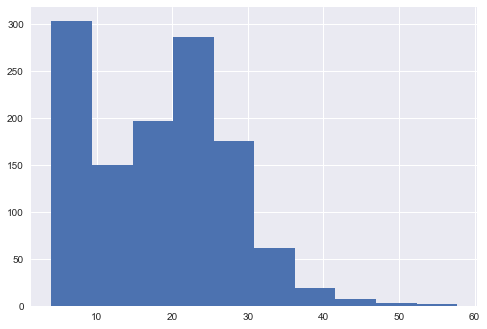

In [98]:
pred['runs_scored_bat_first'].hist()

### saving it to sample submission

In [99]:
submission = test_player[['player_id', 'playing_xi_flag','match_id']]
submission = submission.merge(pred[['player_id', 'match_id','runs_scored_bat_first']] ,on =['match_id','player_id'], how='left')

In [100]:
submission.head()

,player_id,playing_xi_flag,match_id,runs_scored_bat_first
0,1,1.0,2018_1,24.109139
1,24,1.0,2018_1,29.483475
2,114,1.0,2018_1,19.933703
3,131,1.0,2018_1,11.866875
4,175,1.0,2018_1,22.839792


In [101]:
test_player.shape

(2618, 9)

In [102]:
submission.shape

(2632, 4)

### for 2 innings

In [103]:
testing2 = testing[['unique_id', 'match_id', 'player_id','venue_id', 'bowling_team']]

In [104]:
df = batsman_data[['batsman', 'avg_second_ing', 'dot%2', 'total_runs2', 'total_innings_2', 'ability2', '30+_2', 'mom_2', 
             'top_order', 'Price','current_rank' ,'player_id','role','10-','consistency','50s']]

testing2 = testing2.merge(df, on ='player_id', how='left')

In [105]:
testing2['role'] = testing2['role'].map(role_map2)

In [106]:
## avg aganist different teams

temp =(runs_scored[runs_scored['inning'] == 2].groupby(['batsman','bowling_team'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 2].groupby(['batsman','bowling_team'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_team_Avg = temp.reset_index().rename(columns = {0:'avg'}).fillna(0)

## adding team wise avg in val

testing2 = testing2.merge(bat_team_Avg, on = ['batsman','bowling_team'], how='left')
testing2.fillna(0, inplace=True)
testing2.loc[testing2['avg'] == np.inf, 'avg'] = 0

In [107]:
runs_scored

,season,match_id,inning,batsman,batsman_runs,balls_faced,total,dots,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,player_of_match,batting_team,bowling_team,is_out,venue_id
0,2015,1,1,Aaron Finch,5,5,165,3,KKR,field,KKR,0,7,Morne Morkel,MI,KKR,1.0,3
1,2015,1,1,Aditya Tare,7,8,165,4,KKR,field,KKR,0,7,Morne Morkel,MI,KKR,1.0,3
2,2015,1,1,Ambati Rayudu,0,2,165,2,KKR,field,KKR,0,7,Morne Morkel,MI,KKR,1.0,3
3,2015,1,1,Corey Anderson,55,41,165,16,KKR,field,KKR,0,7,Morne Morkel,MI,KKR,0.0,3
4,2015,1,1,Rohit Sharma,98,66,165,25,KKR,field,KKR,0,7,Morne Morkel,MI,KKR,0.0,3
5,2015,1,2,Gautam Gambhir,57,44,166,17,KKR,field,KKR,0,7,Morne Morkel,KKR,MI,1.0,3
6,2015,1,2,Manish Pandey,40,24,166,6,KKR,field,KKR,0,7,Morne Morkel,KKR,MI,1.0,3
7,2015,1,2,Robin Uthappa,9,12,166,8,KKR,field,KKR,0,7,Morne Morkel,KKR,MI,1.0,3
8,2015,1,2,Surya Kumar Yadav,46,21,166,5,KKR,field,KKR,0,7,Morne Morkel,KKR,MI,0.0,3
9,2015,1,2,Yusuf Pathan,14,12,166,6,KKR,field,KKR,0,7,Morne Morkel,KKR,MI,0.0,3


In [108]:
## adding venue id
#runs_scored = runs_scored.merge(match_data[['season','match_id','venue_id']], on = ['season','match_id'] ,how='left')

## avg venue dependent

temp =(runs_scored[runs_scored['inning'] == 2].groupby(['batsman','venue_id'])['batsman_runs'].apply(lambda x: x.sum()))/((runs_scored[runs_scored['inning'] == 2].groupby(['batsman','venue_id'])['is_out'].apply(lambda x: np.count_nonzero(x == 1))))
bat_venue_Avg = temp.reset_index().rename(columns = {0:'avg_venue'}).fillna(0)

## adding it to 

testing2 = testing2.merge(bat_venue_Avg, on = ['batsman','venue_id'], how='left')
testing2.fillna(0, inplace=True)
testing2.loc[testing2['avg_venue'] == np.inf, 'avg_venue'] = 0

## adding avg totals at each venue

temp = runs_scored.groupby('venue_id')['total'].apply(lambda x: x.mean()).reset_index().rename(columns= {'total':'venue_avg_total'})
testing2 = testing2.merge(temp, on='venue_id', how='left')

testing2.fillna(0,inplace=True)

In [109]:
testing2[features2].head()

,avg_second_ing,dot%2,total_runs2,total_innings_2,ability2,30+_2,mom_2,top_order,Price,current_rank,avg,avg_venue,venue_avg_total,role
0,27.785714,37.654321,389.0,18.0,0.222222,4.0,0.777778,0.0,0.0,999.0,10.750000,1.500000,156.961039,21.915663
1,42.687500,33.531746,683.0,21.0,0.476190,10.0,1.523810,1.0,1100.0,42.0,45.250000,47.500000,156.961039,26.871622
2,15.000000,37.662338,105.0,12.0,0.000000,0.0,0.916667,0.0,640.0,999.0,14.666667,17.500000,156.961039,19.436364
3,19.166667,44.578313,115.0,11.0,0.090909,1.0,1.454545,0.0,200.0,999.0,0.000000,28.333333,156.961039,7.109375
4,18.142857,42.654028,254.0,14.0,0.142857,2.0,1.214286,1.0,400.0,999.0,28.000000,28.000000,156.961039,19.436364


In [110]:
testing2.loc[testing2['avg'] == np.inf, 'avg'] = 0

In [111]:
runs2 = rf2.predict(testing2[features2])

In [112]:
pred = testing2[['player_id', 'batsman','match_id']]
pred['runs_scored_bat_second'] = runs2

In [113]:
pred.groupby('batsman')['runs_scored_bat_second'].apply(lambda x: x.sum()).sort_values(ascending=False)

batsman
Brendon McCullum        604.420650
Suresh Raina            546.326752
Rahul Tripathi          519.986748
Rohit Sharma            517.315623
0                       509.200820
Ajinkya Rahane          490.323780
Manish Pandey           484.261290
Virat Kohli             477.004003
Gautam Gambhir          462.495474
Sanju Samson            460.640402
Shikhar Dhawan          454.148021
Murali Vijay            453.984214
Chris Gayle             446.594319
Chris Lynn              445.490345
AB De Villiers          439.692039
Shreyas Iyer            436.811205
Robin Uthappa           436.283558
Aaron Finch             415.497277
Nitish Rana             413.421842
Faf du Plessis          410.391125
Amit Mishra             394.965837
Jos Buttler             392.289740
Rishabh Pant            386.208655
Yuvraj Singh            374.905447
Yusuf Pathan            364.244103
Kieron Pollard          353.446624
Shane Watson            352.651674
KL Rahul                352.631470
Ben Stokes  

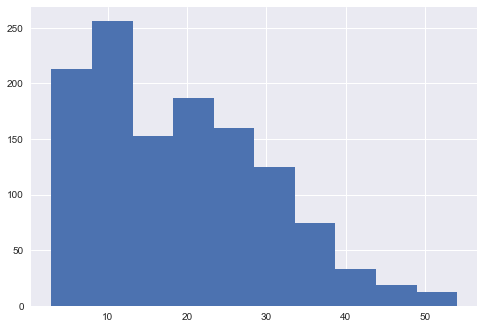

In [114]:
pred['runs_scored_bat_second'].hist()

In [115]:
pred.loc[pred['batsman'] == 0, 'runs_scored_bat_second'] = 5

In [116]:
submission = submission.merge(pred[['player_id', 'match_id','runs_scored_bat_second']] ,on =['match_id','player_id'], how='left')

In [117]:
submission.fillna(0, inplace=True)

In [118]:
submission['runs_scored_bat_first'] = submission['runs_scored_bat_first'].round().astype('int')
submission['runs_scored_bat_second'] = submission['runs_scored_bat_second'].round().astype('int')

In [128]:
### tweaks

submission = submission.merge(player_attributes[['player_id','player_name','role']], on='player_id', how='left')

pure_bowlers = ['Imran Tahir', 'Shardul Thakur',
       'Jasprit Bumrah', 'Pat Cummins', 'Mustafizur Rahman', 'Amit Mishra',
       'Shahbaz Nadeem', 'Trent Boult', 'Mohammed Shami', 'Mohit Sharma', 'Andrew Tye', 'Vinay Kumar', 'Kuldeep Yadav', 'Mitchell Johnson', 'Umesh Yadav',
       'Mohammed Siraj', 'Yuzvendra Chahal', 'Dhawal Kulkarni',
       'Anureet Singh', 'Jaydev Unadkat', 'Siddarth Kaul', 'Rashid Khan']

submission.loc[submission['player_name'].isin(pure_bowlers), 'runs_scored_bat_first'] = 0
submission.loc[submission['player_name'].isin(pure_bowlers), 'runs_scored_bat_second'] = 0

In [140]:
submission = submission.drop(['player_name','role'],axis=1)

In [141]:
submission.to_csv('saved/sub_runs.csv', index=False)

In [142]:
submission

,player_id,playing_xi_flag,match_id,runs_scored_bat_first,runs_scored_bat_second
0,1,1.0,2018_1,24,20
1,24,1.0,2018_1,29,37
2,114,1.0,2018_1,20,17
3,131,1.0,2018_1,12,9
4,175,1.0,2018_1,23,23
5,177,1.0,2018_1,20,17
6,189,1.0,2018_1,21,26
7,249,1.0,2018_1,25,15
8,254,0.0,2018_1,0,0
9,309,0.0,2018_1,0,0
